In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import time
import gget
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
import utils as ut

In [2]:
fullpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/processed_data/all_subclustered.h5ad"
raw = sc.read(fullpath)

# filter out non-neurons
cluster_query = ['C3', 'C8']
adata = raw[raw.obs['Nueron_Cluster'].isin(cluster_query)]
pdf = adata.copy()
pdf


AnnData object with n_obs × n_vars = 6927 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat', 'U1', 'U2', 'cell_type', 'NU1', 'NU2', 'neuron_cluster_num', 'Nueron_Cluster', 'neuron_cluster_cat', 'HypoMap Predicitions', 'HypoMap Subclusters', 'neuron_subtype', 'batch_name'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'C7_named_clean_colors', 'Cluster', 'Cluster_colors', 'Diet_colors', 'HypoMap Predicitions_colors', 'HypoMap Subclusters_colors', 'Nueron_Cluster', 'Nueron_Cluster_colors', 'Sex_colors', 'batch_colors', 'cell_type_colors', 'dendrogram_Cluster', 'dendrogram_Nueron_Cluster', 'dendrogram_cell_type', 'dendrogram_neuron_subtype', 'hvg', 'leide

2023-11-17 10:12:52.185098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 10:12:52.364074: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 10:12:52.373149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-17 10:12:52.373163: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

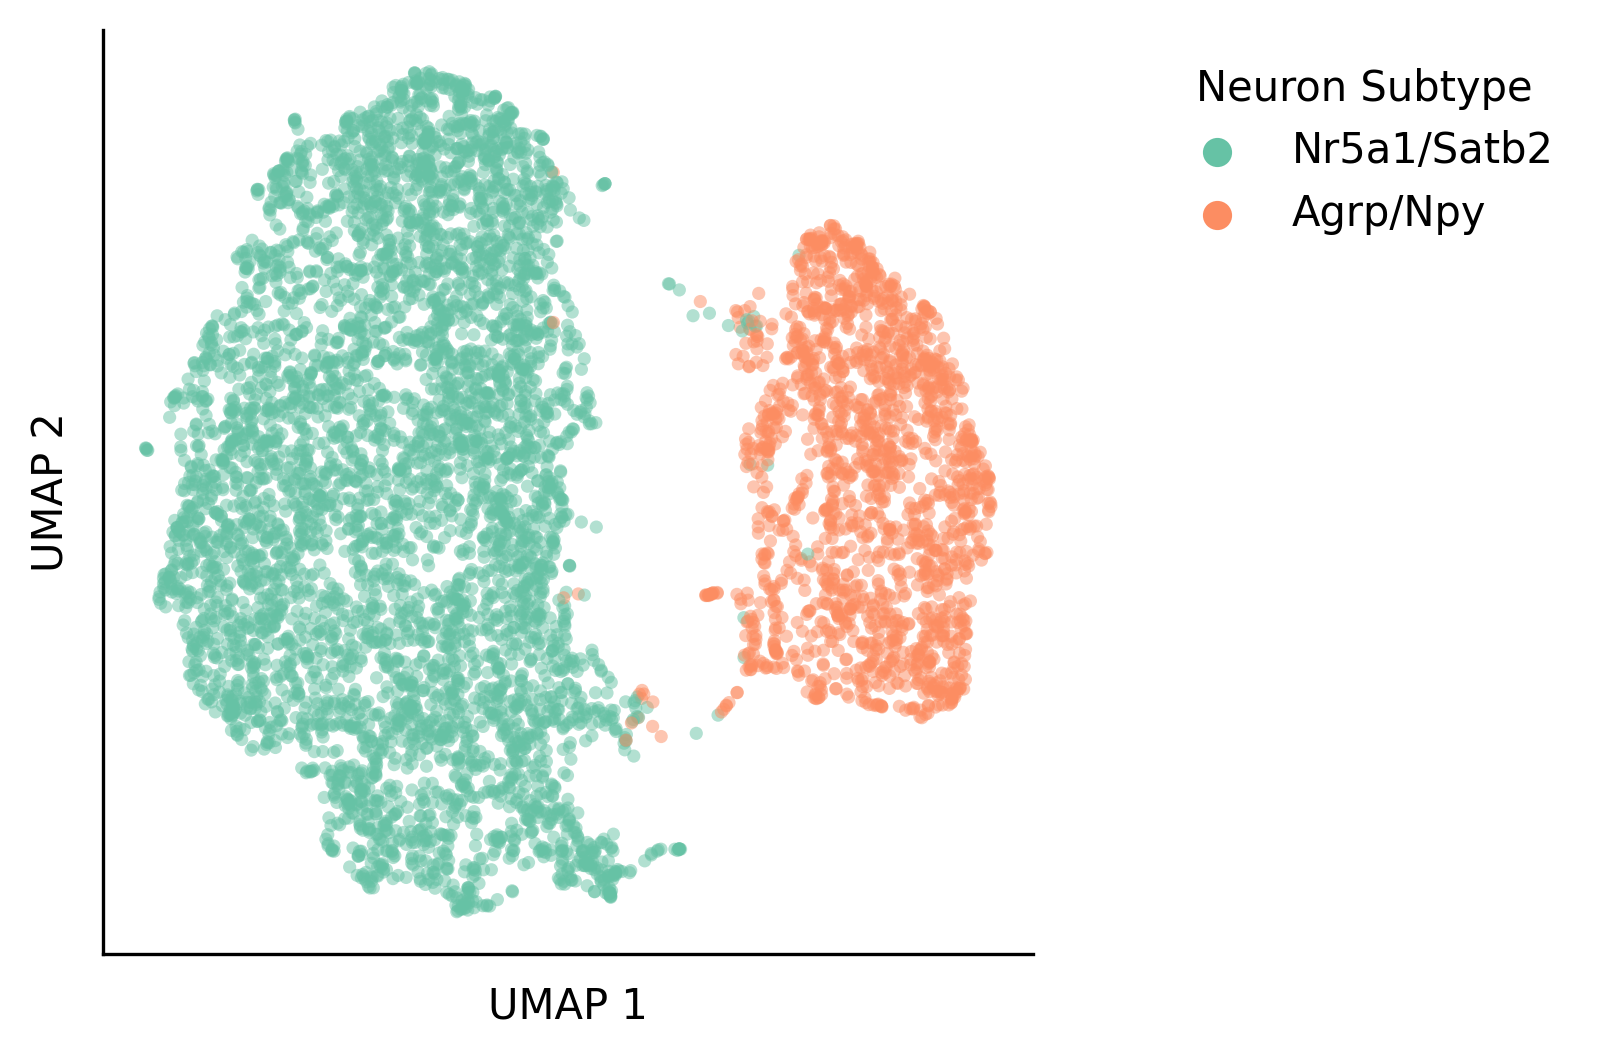

In [3]:
# new embedding
min_distance = 0.1
spread = 5
NPCA = 10
knn = 5

sc.pp.neighbors(pdf, n_neighbors=knn, n_pcs=NPCA)

sc.tl.umap(pdf, 
           min_dist=min_distance, 
           spread=spread)

pdf.obs['NSU1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['NSU2'] = pdf.obsm['X_umap'][:, 1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(pdf.obs.sort_values(by='cluster_num'),
                x='NSU1',
                y='NSU2',
                hue='neuron_subtype',
                palette='Set2',
                linewidth=0.25,
                alpha=0.5,
                s=10,
                ec='none')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("UMAP 2")
ax.set_xlabel("UMAP 1")

sns.move_legend(ax,
                loc='upper right',
                frameon=False,
                title='Neuron Subtype',
                bbox_to_anchor=(1.6, 1),)
sns.despine()

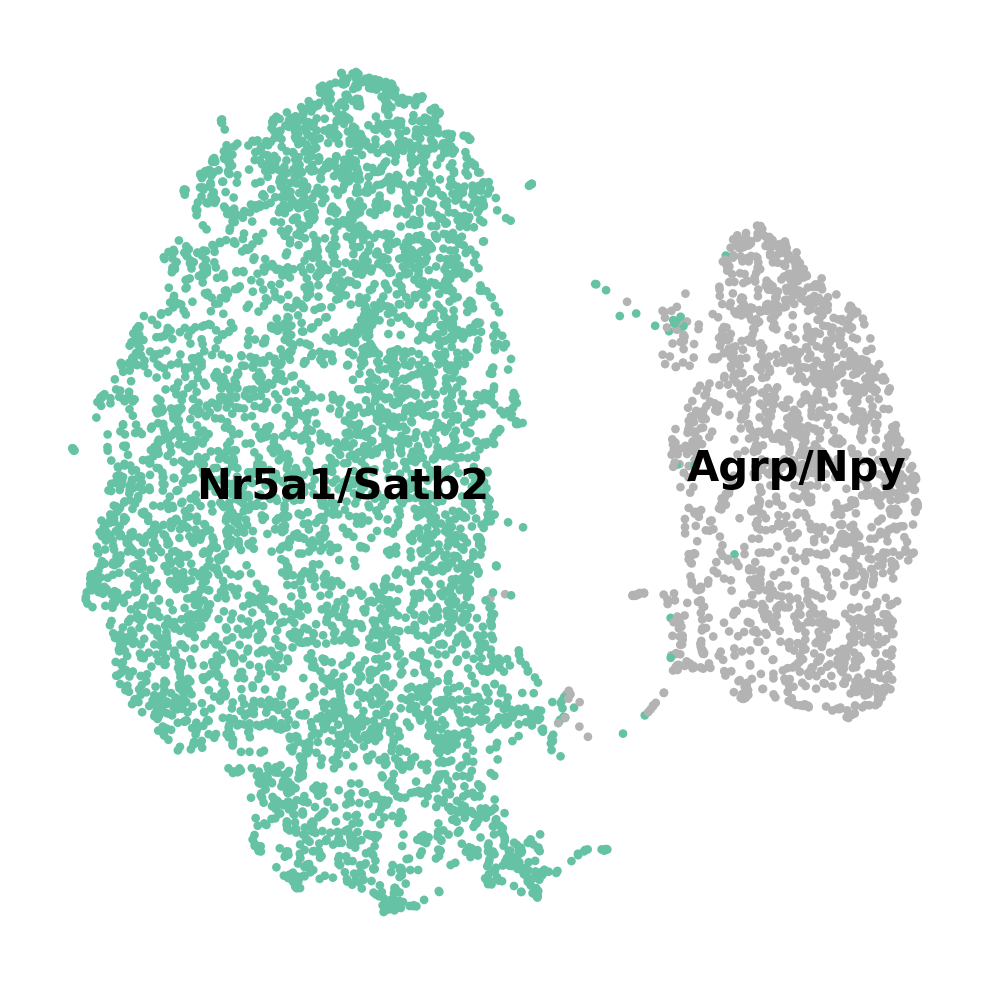

In [4]:
sc.pl.umap(pdf, 
           color='neuron_subtype', 
           legend_loc='on data', 
           title='', 
           palette='Set2',
           frameon=False,)

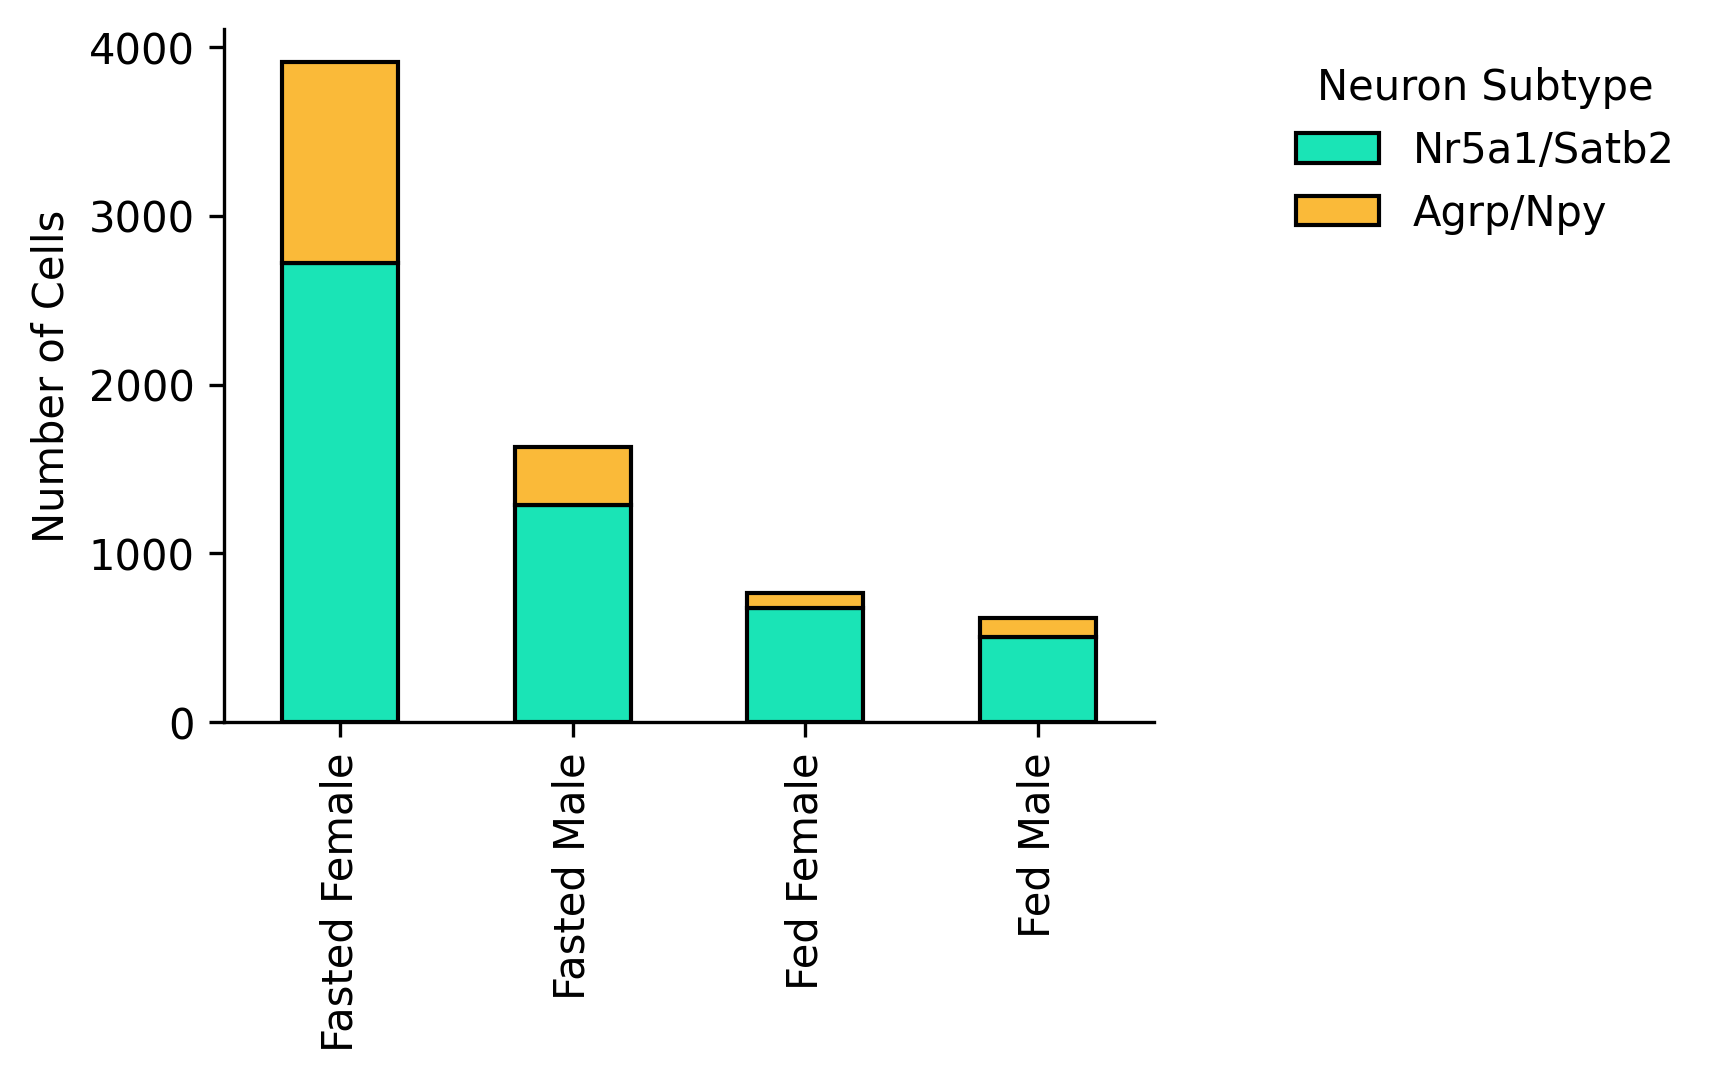

In [5]:
def get_colors(data, cmap):
    """A function to return seaborn colormap
    dict from a colum """
    color_list = sns.palettes.color_palette(cmap,
                                            data.nunique(), 
                                            as_cmap=False)
    return color_list


gx = pdf.obs.groupby(['batch', 'neuron_subtype'])['n_genes'].count()
gx = gx.reset_index(drop=False)

gx = pd.pivot_table(gx, 
                    index='batch',
                    columns='neuron_subtype',
                    values='n_genes')


batch_map = { 
    'fasted_f' : 'Fasted Female', 
    'fasted_m' : 'Fasted Male', 
    'fed_f' : 'Fed Female', 
    'fed_m' : 'Fed Male', 
}


color_list = get_colors(gx.columns, 'turbo')

gx = gx.reset_index(drop=False)
gx['batch'] = gx['batch'].map(batch_map)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3


gx.plot(x='batch', 
        kind='bar', 
        stacked=True,
        color=color_list,
        ec='k',
        )

sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="Neuron Subtype",
                bbox_to_anchor=(1.6, 1))

plt.xlabel("")
plt.ylabel('Number of Cells')
sns.despine()


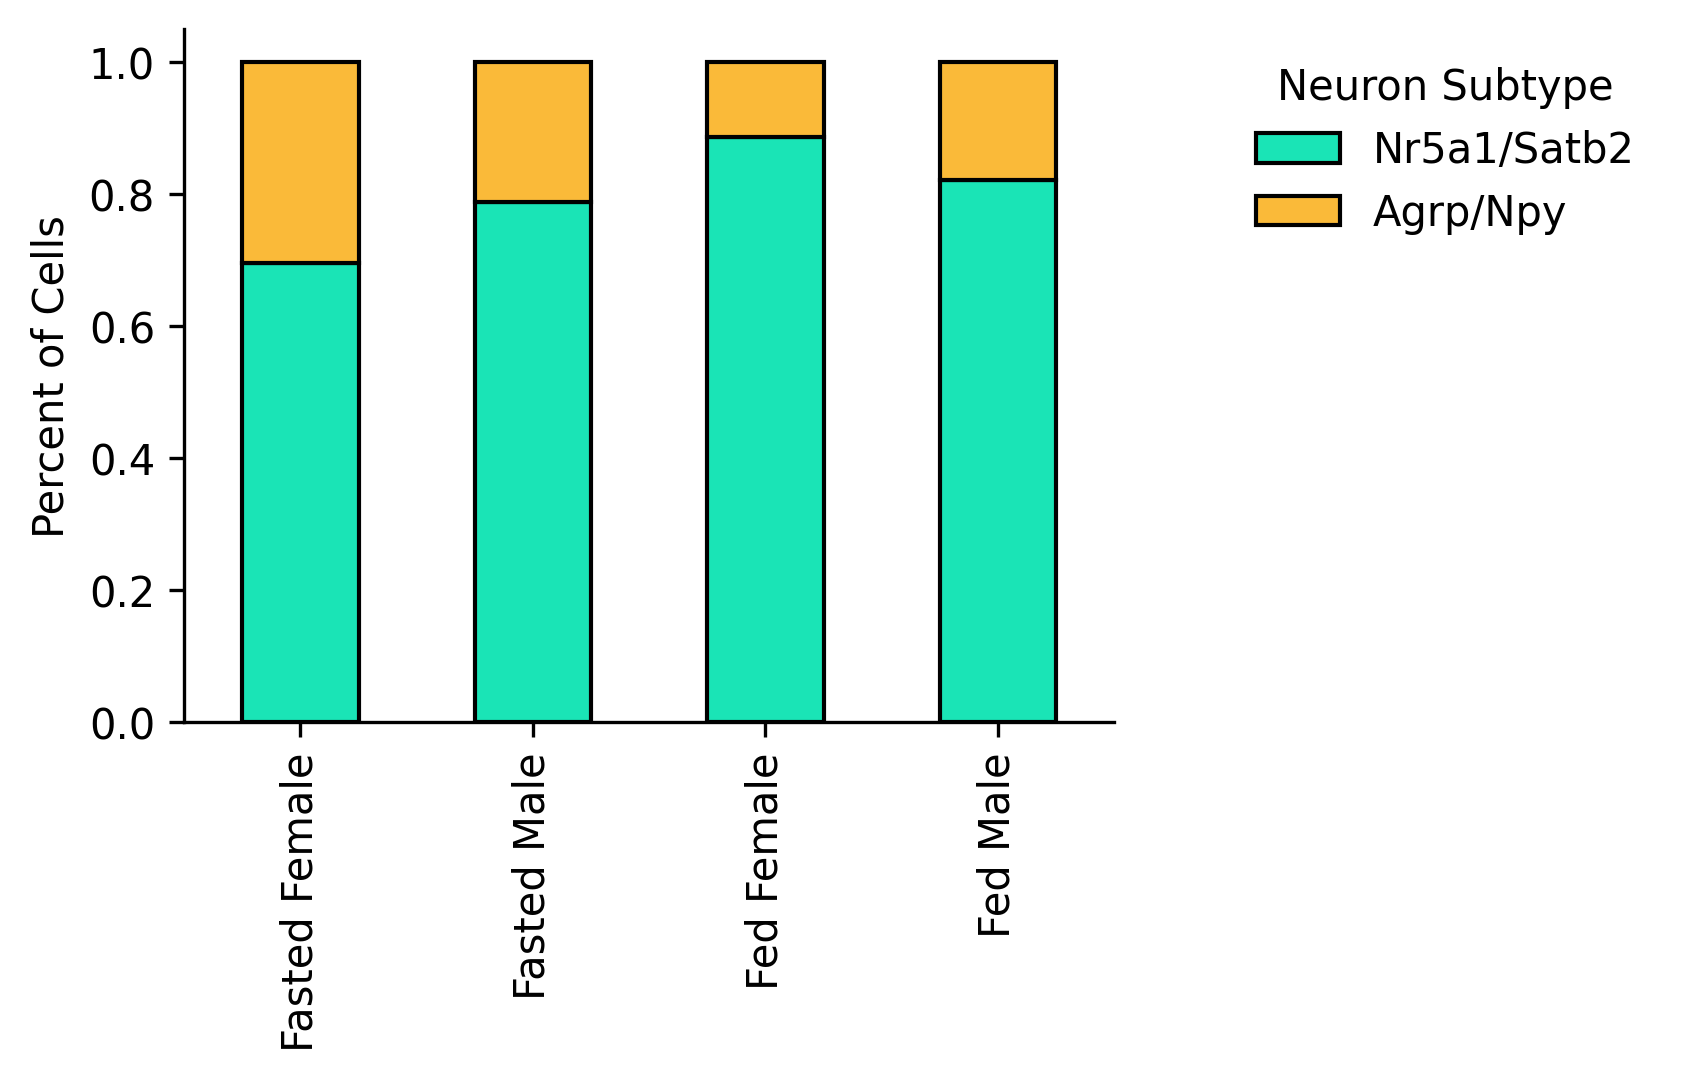

In [6]:
gx = pdf.obs.groupby(['batch', 'neuron_subtype'])['n_genes'].count()
gx = gx.reset_index(drop=False)

gx = pd.pivot_table(gx, 
                    index='batch',
                    columns='neuron_subtype',
                    values='n_genes')

# normalize rows
row_sums = gx.sum(axis=1)
gx = gx.divide(row_sums, axis=0)


batch_map = { 
    'fasted_f' : 'Fasted Female', 
    'fasted_m' : 'Fasted Male', 
    'fed_f' : 'Fed Female', 
    'fed_m' : 'Fed Male', 
}


color_list = get_colors(gx.columns, 'turbo')

gx = gx.reset_index(drop=False)
gx['batch'] = gx['batch'].map(batch_map)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3


gx.plot(x='batch', 
        kind='bar', 
        stacked=True,
        color=color_list,
        ec='k',
        )

sns.move_legend(plt.gca(), 
                loc='upper right',
                frameon=False,
                title="Neuron Subtype",
                bbox_to_anchor=(1.6, 1))

plt.xlabel("")
plt.ylabel('Percent of Cells')
sns.despine()


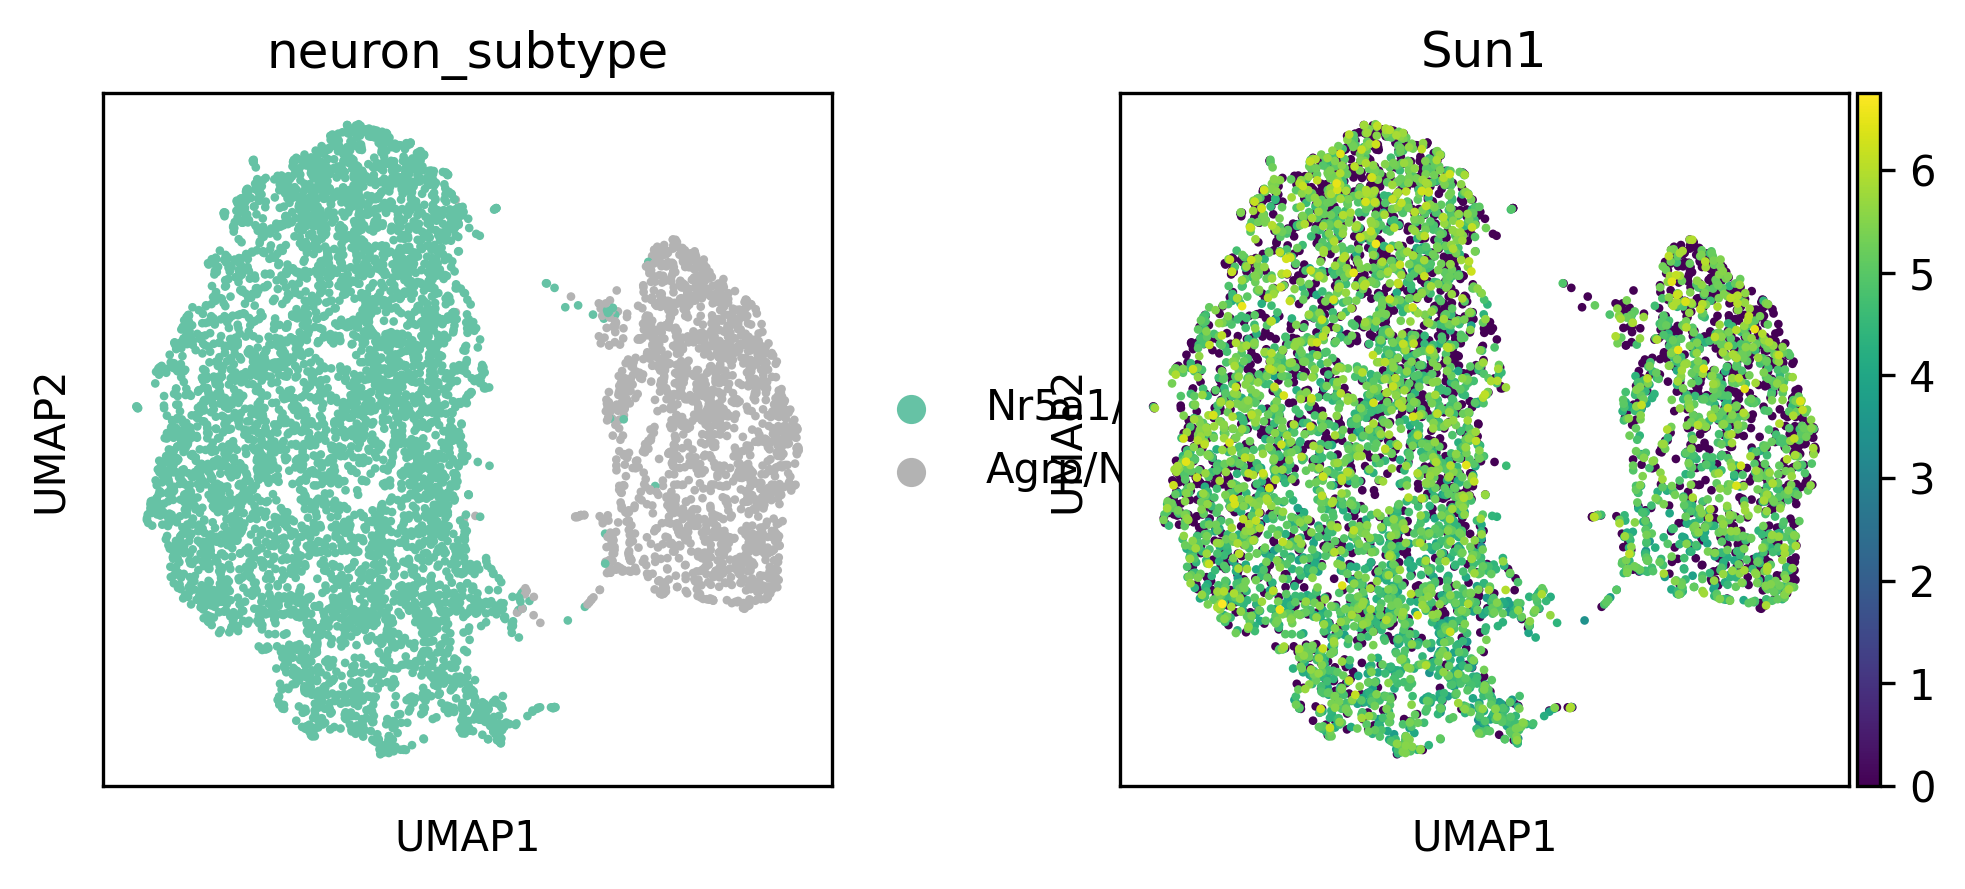

In [7]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(pdf, color=['neuron_subtype', 'Sun1'])

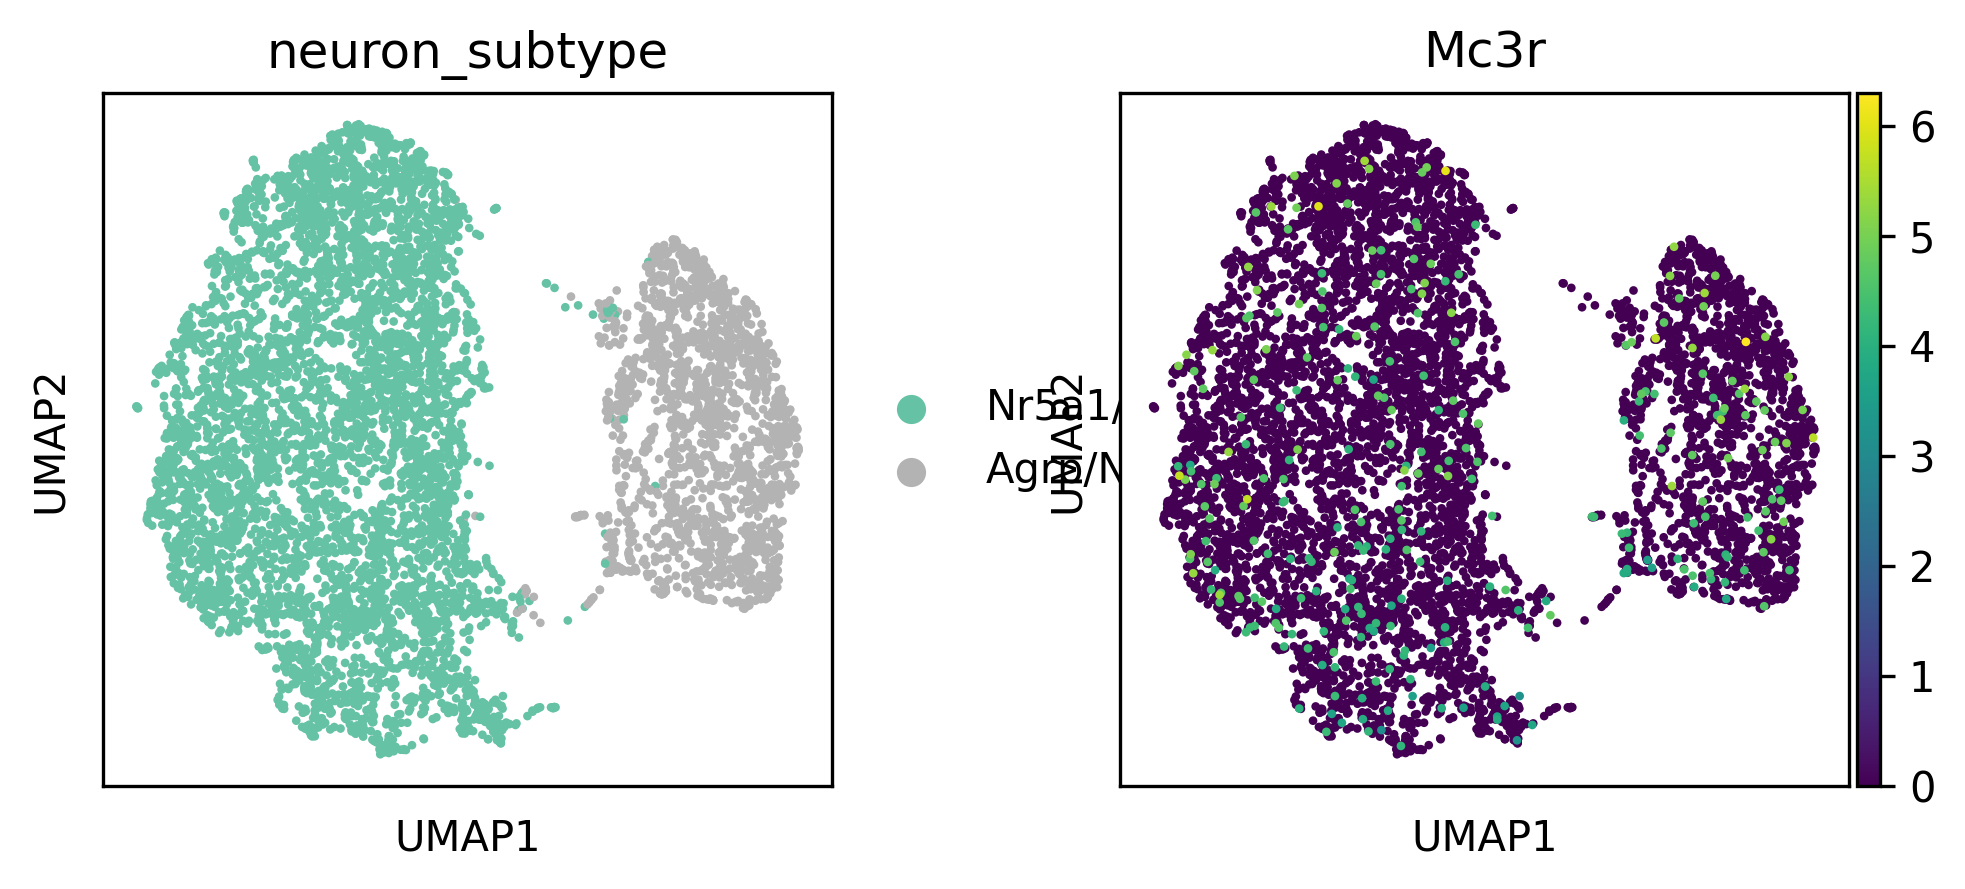

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(pdf, color=['neuron_subtype', 'Mc3r'])

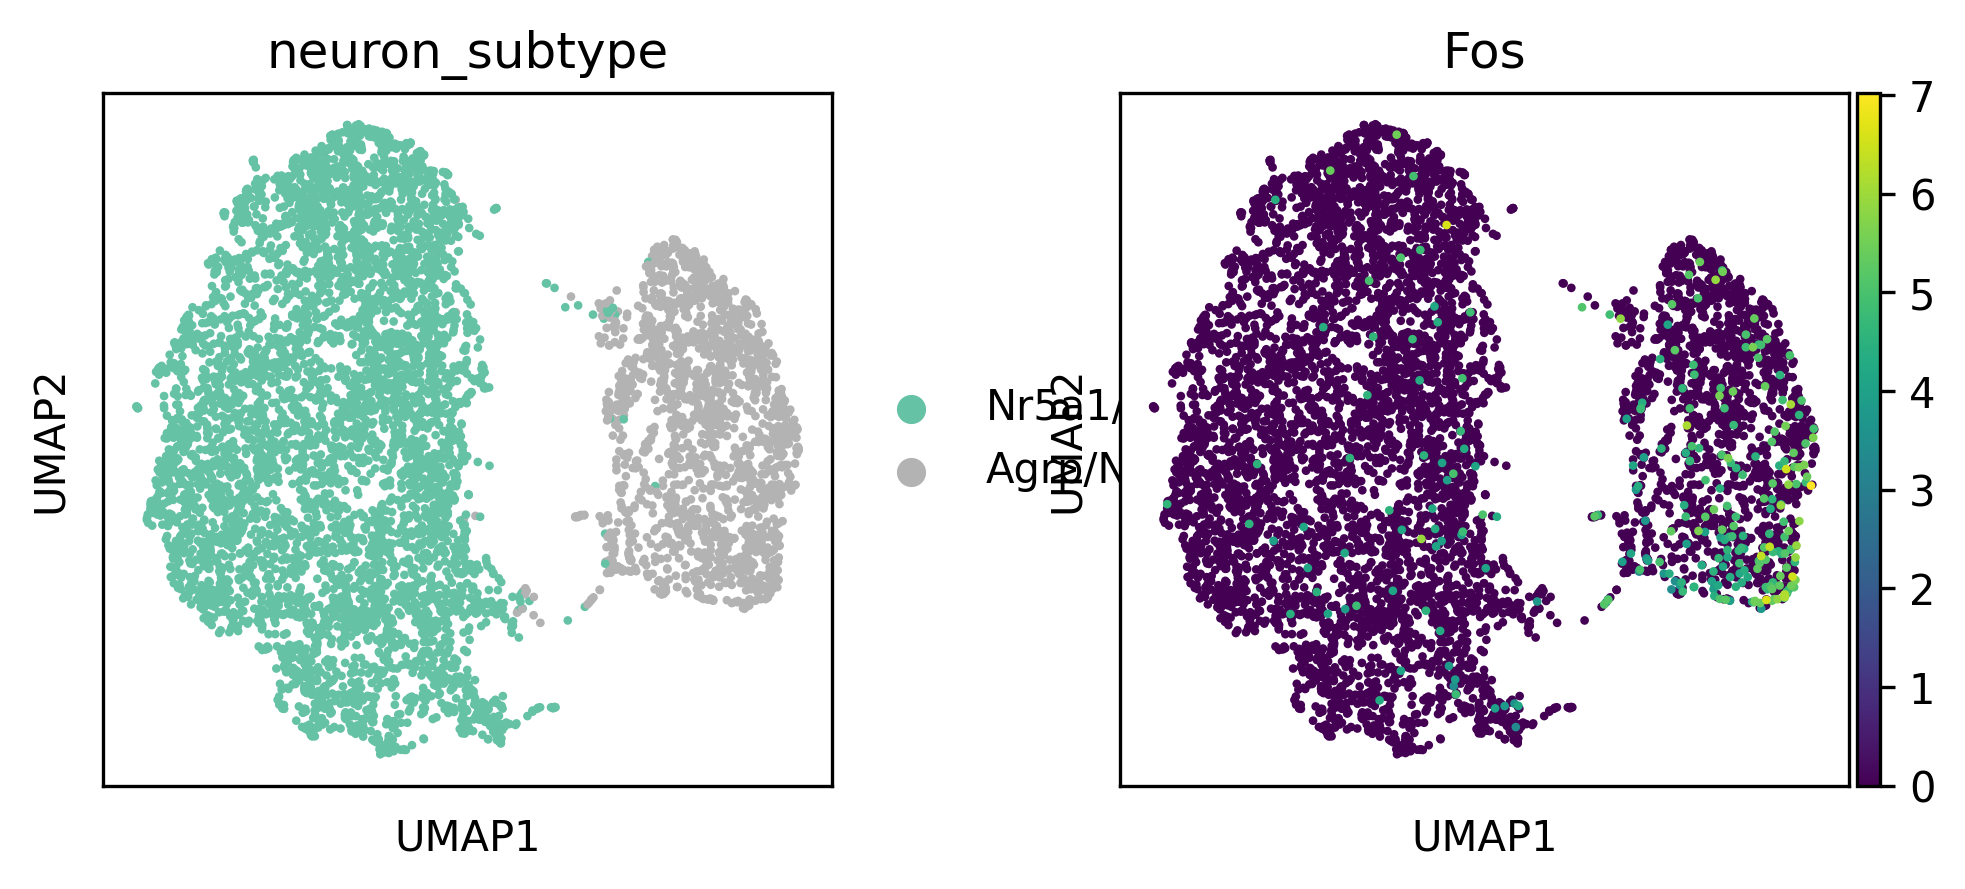

In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sc.pl.umap(pdf, color=['neuron_subtype', 'Fos'])

In [10]:
pdf.obs.columns

Index(['batch', 'reference_embedding_C7_named',
       'reference_embedding_C25_named', 'C25_named', 'C7_named',
       'reference_embedding_C7_named_clean',
       'reference_embedding_C25_named_clean', 'C25_named_clean',
       'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type',
       'n_genes', 'color', 'leiden', 'cluster_num', 'Cluster', 'cluster_cat',
       'U1', 'U2', 'cell_type', 'NU1', 'NU2', 'neuron_cluster_num',
       'Nueron_Cluster', 'neuron_cluster_cat', 'HypoMap Predicitions',
       'HypoMap Subclusters', 'neuron_subtype', 'batch_name', 'NSU1', 'NSU2'],
      dtype='object')

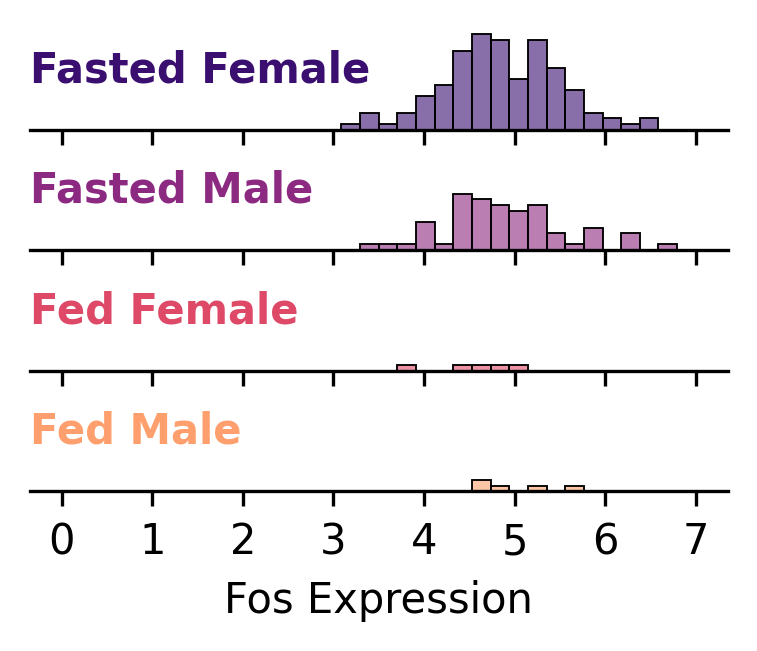

In [11]:
gene = 'Fos'

pdx = pdf.obs.copy()
pdx['exp'] = np.ravel(pdf[:, gene].X.todense())
pdx = pdx[pdx['exp'] > 0]
pdx = pdx[pdx['neuron_subtype'] == 'Agrp/Npy']


g = sns.FacetGrid(pdx, 
                  row="batch_name", 
                  hue="batch_name", 
                  aspect=6, 
                  height=0.5, 
                  palette='magma')

g.map(sns.histplot, 
      "exp",
      bins=np.linspace(0, 7, 35),
      alpha=0.6,)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 0.6, 
            label, 
            fontweight="bold", 
            color=color,
            ha="left",
            va="center", 
            transform=ax.transAxes)


g.map(label, "exp")
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set(xticks=list(range(8)), xlabel="Fos Expression")
g.despine(left=True)

<AxesSubplot: xlabel='Diet', ylabel='fos_exp'>

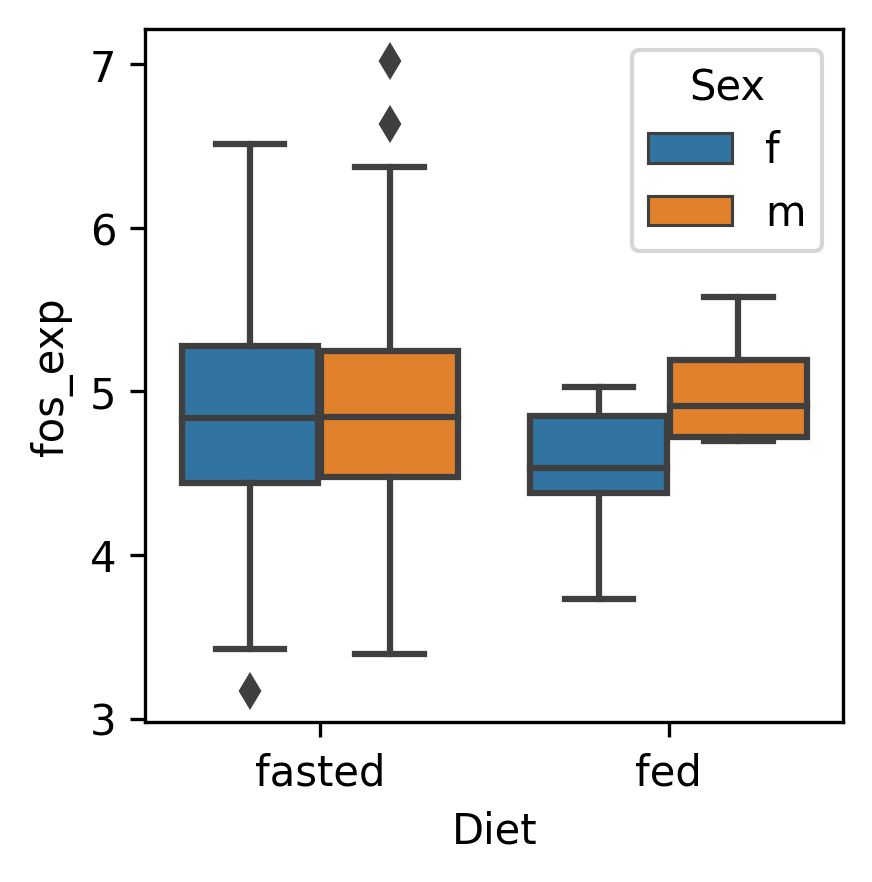

In [12]:
agrp = pdf[pdf.obs['neuron_subtype'] == 'Agrp/Npy']

agrp.obs['fos_exp'] = np.ravel(agrp[:, 'Fos'].X.todense())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

plotter = agrp.obs.copy()
plotter = plotter[plotter['fos_exp'] > 0]

sns.boxplot(data=plotter,
            x='Diet',
            y='fos_exp',
            hue='Sex')

# volcano plots for Agrp Neurons

In [16]:
agrp = pdf[pdf.obs['neuron_subtype'] == 'Agrp/Npy']


key = 'agrp_by_diet'
# get marker genes
sc.tl.rank_genes_groups(agrp, 
                        groupby='Diet',
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(agrp, 
                                  group='fasted',
                                  key=key)

deg.head()


,names,scores,logfoldchanges,pvals,pvals_adj
0,Mast4,13.539282,2.033276,9.168045e-42,7.658374e-38
1,Agrp,11.728373,1.699531,9.119466e-32,2.856673e-28
2,Cdc37l1,11.391872,2.240772,4.590208e-30,1.278118e-26
3,Fkbp5,11.377630,3.089760,5.404853e-30,1.354456e-26
4,Carmil1,11.209152,2.428973,3.676978e-29,7.678755e-26


In [45]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.05, point['y'], str(point['val']), fontsize=4,)

In [ ]:
alpha = 0.01
sig = deg[deg['pvals_adj'] <= alpha ].reset_index(drop=True)

sig['logp'] = -1 * np.log10(sig['pvals'])


label_list = [
    'Agrp',
    'Pomc',
    'Ghr',
    'Negr1',
    'Mast4',
    'Lepr',
    'Sorcs1',
    'Gab1',
    # 'Socs2',
]


sig['color'] = np.where(sig['names'].isin(label_list), 'r', 'C0')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(data=sig, 
            x='logfoldchanges',
            y='logp',
            ec='none',
            c=sig['color'].to_list(),
            alpha=0.8,
            zorder=1,
            s=2)

plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")
plt.axvline(x=0, lw=1, c='k', zorder=2)


ax = plt.gca()

label_df = sig[sig['names'].isin(label_list)]
label_point(label_df['logfoldchanges'], 
            label_df['logp'], 
            label_df['names'], 
            ax) 

sns.despine()

In [55]:
sig = sig.sort_values(by='logfoldchanges', ascending=True)
sig.head(20)


,names,scores,logfoldchanges,pvals,pvals_adj,logp,color
782,Pomc,-11.154609,-4.776907,6.799093e-29,1.310656e-25,28.167549,r
786,Evi5,-12.746891,-3.149927,3.244274e-37,1.626030e-33,36.488883,C0
777,Tafa1,-9.841709,-3.028340,7.443511e-23,6.908681e-20,22.128222,C0
464,Adgrg6,-4.041725,-2.964216,5.305946e-05,2.292535e-03,4.275237,C0
748,Per3,-7.788614,-2.924255,6.774844e-15,2.116218e-12,14.169101,C0
780,Filip1,-10.462441,-2.891032,1.285016e-25,1.694868e-22,24.891092,C0
718,Eif2s3y,-6.735173,-2.862038,1.637352e-11,3.309036e-09,10.785858,C0
714,Uty,-6.637980,-2.784731,3.180112e-11,6.130277e-09,10.497558,C0
763,Kcnh8,-8.516916,-2.759826,1.638576e-17,7.332627e-15,16.785533,C0
742,Zfr2,-7.668770,-2.643650,1.736533e-14,5.002014e-12,13.760317,C0


In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(pdf, color=['neuron_subtype', 'Diet', 'Sex'])

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(pdf, color=['neuron_subtype', 'batch'])

In [ ]:

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

pdf.obs['HypoMap Predicitions'] = pdf.obs['reference_embedding_C7_named_clean'].astype('string').str.strip()
pdf.obs['HypoMap Predicitions'] = np.where(~pdf.obs['HypoMap Predicitions'].isin(['GABA', 'GLU']), 'Other', pdf.obs['HypoMap Predicitions'] )



sc.pl.umap(pdf, color=['Nueron_Cluster', 'HypoMap Predicitions'])

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

pdf.obs['HypoMap Subclusters'] = pdf.obs['C25_named_clean'].astype(str).str.strip()

whitelist = [
    'GABA-2', 
    'GLU-1', 
    'GLU-2', 
    'GLU-8', 
    'GABA-5', 
    'GABA-4', 
    'GABA-7', 
    'GLU-3', 
    'GLU-5', 
    'GLU-6', 
    'GABA-3',
    'GABA-6',
    'GLU-7',
]

pdf.obs['HypoMap Subclusters'] = np.where(~pdf.obs['HypoMap Subclusters'].isin(whitelist), 'Other', pdf.obs['HypoMap Subclusters'] )

sc.pl.umap(pdf, color=['Nueron_Cluster', 'HypoMap Subclusters'])

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sc.pl.umap(pdf, color=['Nueron_Cluster', 'n_genes'])

In [ ]:
key = 'neuron_subtype'
# get marker genes
sc.tl.rank_genes_groups(pdf, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key=key)

deg.head()

In [ ]:
alpha = 0.01
n_print = 25

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 9

for cluster, group in deg.groupby('group'):

    cdf = group[group['pvals_adj'] <= alpha]
    cdf = cdf[~cdf['names'].str.endswith("Rik")]
    cdf = cdf[~cdf['names'].str.startswith("MT-")]
    cdf = cdf[~cdf['names'].str.startswith("Gm")]

    
    cdf = cdf.sort_values(by='logfoldchanges', ascending=False,)
    label_genes = cdf['names'].head(n_print).to_list()
    label_genes.insert(0, None) # buffer top DEG so that it's plotted


    fig, axs = plt.subplots(5, 5)
    axs = axs.ravel()

    for i, g in enumerate(label_genes[:-1]):
        gdf = pdf.obs.copy()
        if i == 0:
            colors = np.where(gdf['Nueron_Cluster'] == cluster, 'r', 'lightgrey')
            order = np.argsort(colors)
            axs[i].scatter(gdf['NSU1'][order], 
                           gdf['NSU2'][order],
                           c=colors[order],
                           s=1,
                           alpha=0.2,
                           ec='none')
            axs[i].set_title("Cells")
        else:
            v = pdf[:, [g]].X.todense()
            gdf['exp'] = np.ravel(v)
        
            order = np.argsort(gdf['exp'])
        
            axs[i].scatter(gdf['NSU1'][order], 
                           gdf['NSU2'][order],
                           c=gdf['exp'][order],
                           s=1,
                           alpha=0.2,
                           ec='none')
            
            axs[i].set_title(g)

        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("")
        axs[i].set_ylabel("")

    plt.suptitle(f"Cluster {cluster}")
    sns.despine()
    plt.show()

In [ ]:
label_genes = [
    'Mc3r',
    'Agrp',
    'Lepr',
    'Otp',
    'Acvr1c',
    'Dlk1',
    'Fezf1',
    'Nr5a1',
    'Pomc',
    'Crabp1',
    'Sst',
    'Bdnf',
    'Cartpt',
    'Ghrh',
    'Trh',
    'Tac2',
    'Tac1',
    'Mt2',
    'Coch',
    'Gal',
    'Nts',
    'Nfib',
    'Foxp2',
    'Adcyap1',
    'Esr1',]

print(f"{len(label_genes)=}")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 9

fig, axs = plt.subplots(5, 5)
axs = axs.ravel()

for i, g in enumerate(label_genes):
    v = pdf[:, [g]].X.todense()

    gdf = pdf.obs.copy()
    gdf['exp'] = np.ravel(v)

    order = np.argsort(gdf['exp'])

    axs[i].scatter(gdf['NSU1'][order], 
                   gdf['NSU2'][order],
                   c=gdf['exp'][order],
                   s=2,
                   alpha=0.3,
                   ec='none')
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])

    axs[i].set_xlabel("")
    axs[i].set_ylabel("")

    axs[i].set_title(g)


sns.despine()
plt.tight_layout()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 3

sc.pl.rank_genes_groups_heatmap(pdf, 
                                n_genes=30, 
                                groupby='neuron_subtype',
                                key='neuron_subtype',
                                cmap='viridis', 
                                dendrogram=False,
                                figsize=(10,7))

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 4

sc.pl.rank_genes_groups_dotplot(pdf, 
                                n_genes=10, 
                                values_to_plot='logfoldchanges',
                                vmax=7, 
                                vmin=-7,
                                cmap='RdYlBu_r',
                                key='neuron_subtype',)

In [ ]:
res = []

for cell_type in pdf.obs['neuron_subtype'].unique():

    # subset the data by cell type
    cdf = pdf[pdf.obs['neuron_subtype'] == cell_type].copy()

    key = f'{cell_type}_by_diet'

    sc.tl.rank_genes_groups(cdf, 
                            groupby='Diet',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf, 
                                      group='fasted',
                                      key=key)

    ax = sc.pl.rank_genes_groups_dotplot(cdf, 
                                key=key, 
                                n_genes=5, 
                                figsize=(5, 1.5),
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=1, 
                                vmax=7, 
                                vmin=-7,
                                show=False,
                                cmap='RdYlBu_r')

    ax['mainplot_ax'].set_title(f"{cell_type}", y=1.5)

    plt.show()

    
    deg['cell_type'] = cell_type
    res.append(deg)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
res = []

for cell_type in pdf.obs['neuron_subtype'].unique():

    # subset the data by cell type
    cdf = pdf[pdf.obs['neuron_subtype'] == cell_type].copy()

    key = f'{cell_type}_by_sex'

    sc.tl.rank_genes_groups(cdf, 
                            groupby='Sex',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf, 
                                      group='f',
                                      key=key)

    ax = sc.pl.rank_genes_groups_dotplot(cdf, 
                                key=key, 
                                n_genes=5, 
                                figsize=(5, 1.5),
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=1, 
                                vmax=7, 
                                vmin=-7,
                                show=False,
                                cmap='RdYlBu_r')

    ax['mainplot_ax'].set_title(f"{cell_type}", y=1.5)

    plt.show()

    
    deg['cell_type'] = cell_type
    res.append(deg)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
res = []


pdf.obs['batch_name'] = pdf.obs['batch'].map(batch_map)

for cell_type in pdf.obs['neuron_subtype'].unique():

    # subset the data by cell type
    cdf = pdf[pdf.obs['neuron_subtype'] == cell_type].copy()

    key = f'{cell_type}_by_diet'

    sc.tl.rank_genes_groups(cdf, 
                            groupby='batch_name',
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')

    deg = sc.get.rank_genes_groups_df(cdf, 
                                      group=None,
                                      key=key)

    ax = sc.pl.rank_genes_groups_dotplot(cdf, 
                                key=key, 
                                n_genes=5, 
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=1, 
                                vmax=7, 
                                vmin=-7,
                                show=False,
                                cmap='RdYlBu_r')

    ax['mainplot_ax'].set_title(f"{cell_type} ({cell_type})", y=2)

    plt.show()

    
    deg['cell_type'] = cell_type
    res.append(deg)


res = pd.concat(res)
print(f"{res.shape=}")
res.head()
